# Data Science Course Project 
# Group No. 32
# Project: **Road Lane Line Detection** 

### Group Members
   #### Roll No  	     GR No   	   Name
   ####      09 	    11810785        Yashaswi Ghune
   ####      32  	    11810314        Samruddhi Jadhav
   ####      36  	    11920017        Sakshi Jagtap
   ####      62  	    11810462        Punamtanvi Kshatriya



## Import Packages

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
#magic function - draws static images in the notebook
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


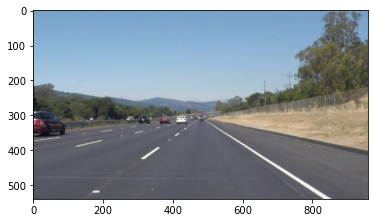

In [11]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 

## Helper Functions

In [12]:
import math

def grayscale(img):
    #Applies the Grayscale transform
    #This will return an image with only one color channel
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    #Applies the Canny transform
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    #Applies a Gaussian Noise kernel
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
   
    #Applies an image mask.
    
   # Only keeps the region of the image defined by the polygon formed from `vertices`. The rest of the image is set to black.
    #`vertices` should be a numpy array of integer points.
    
    # Generate black image of the same size as the original image.
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count    ## 255 is the mask color
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Bitwise AND between canny image and mask image
    # The AND of the values for each pixel of the input images scanny image and mask image is the pixel value
    # of the output image i.e masked_image
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):    
    #This function draws `lines` with `color` and `thickness`.    
    #Lines are drawn on the image inplace (mutates the image).
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    #`img` should be the output of a Canny transform.
    #Returns an image with hough lines drawn.
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)               
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    #`img` is the output of the hough_lines(), An image with lines drawn on it.
    #Should be a black image with lines drawn on it.
    #`initial_img` should be the image before any processing.
    #The result image is computed as follows:
    #initial_img * α + img * β + γ
    return cv2.addWeighted(initial_img, α, img, β, γ)

def display_img(img):
    #This function is used to display images inline which are read using cv2.
    if img.ndim > 2:
        plt.imshow(img)
        plt.show()
    else:
        plt.imshow(img, cmap = 'gray')
        plt.show()

# Testing on images and video without extrapolating detected lines

## Test Images

In [13]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



In [14]:
#image output folder
img_out_folder = 'test_images_output/'

def detect_lane_images(extension):
    """
    This function encapsulates the entire pipeline used for lane detection
    Steps :
    1.Input image
    2.Grayscale
    3.Gaussian filter
    4.Canny edge detection
    5.ROI
    6.Hough lines
    
    'extension' is used when saving images, it is appended at the end of the file name ex. '_output.jpg'
    """
    for input_image in os.listdir('test_images/'):
        
        out_img_name = img_out_folder + input_image[:-4] + extension
        
        # Get the original Image
        input_image = cv2.cvtColor(cv2.imread(os.path.join('test_images', input_image)), cv2.COLOR_BGR2RGB)
                                     
        # Check if the image was loaded properly
        if input_image is None: 
            raise Exception("could not load image !")
        
        # Convert image to grayscale so that we can work with only single channel
        gray_image = grayscale(input_image)
        
        # Apply gaussian filtering to smoothen the image
        gauss_image = gaussian_blur(gray_image, 5)
        
        # Canny edge detection
        canny_image = canny(gauss_image, 120, 240)
        
        # ROI
        # A triangular polygon to segment the lane area and discarded other irrelevant parts in the image
        # Defined by three (x, y) coordinates 
        vertices = np.array([[(0, image.shape[0]), (400, 350), (550, 350), (image.shape[1], image.shape[0])]])
        ROI_image = region_of_interest(canny_image, vertices)
        
        # probabilistic Hough lines
        
        rho = 1                  #Distance resolution in pixels
        theta = np.pi/180        #Angle resolution in radians
        threshold = 10           #Min. number of intersecting points to detect a line 
        min_line_length = 20     #Line segments shorter than this length are rejected
        max_line_gap = 10        #Max gap allowed between line segments to treat them as a single line
        
        hough_image = hough_lines(ROI_image, rho, theta, threshold, min_line_length, max_line_gap)
        
        # Get the lines on the original image
        result = weighted_img(hough_image, input_image)
        
        # Display stages output images
        print("Input Image")
        display_img(input_image)
        print('Canny edge detection on entire image')
        display_img(canny_image)
        print('ROI applied to edge detected image')
        display_img(ROI_image)
        print('Hough Lines on ROI canny edge detected image')
        display_img(hough_image)
        print('Lines on original image')
        display_img(result)
        
        #saving final images
        cv2.imwrite(out_img_name, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

Input Image


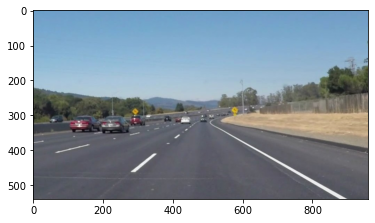

Canny edge detection on entire image


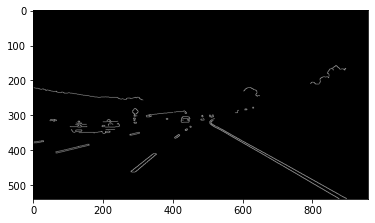

ROI applied to edge detected image


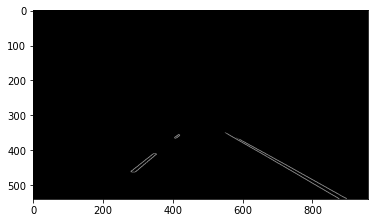

Hough Lines on ROI canny edge detected image


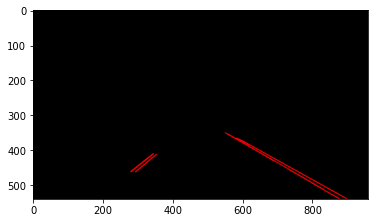

Lines on original image


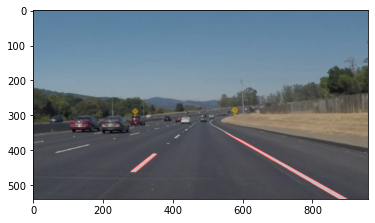

Input Image


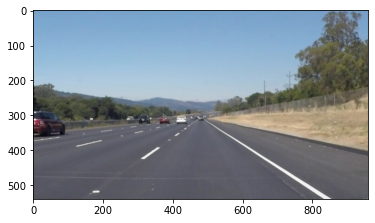

Canny edge detection on entire image


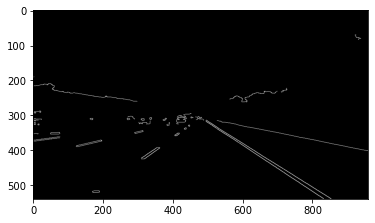

ROI applied to edge detected image


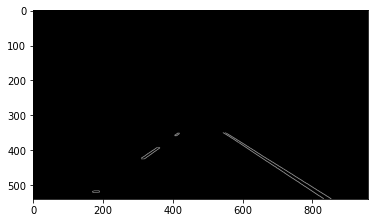

Hough Lines on ROI canny edge detected image


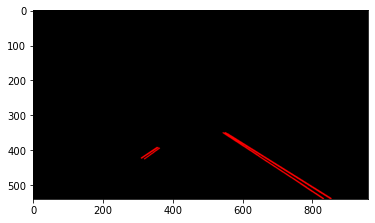

Lines on original image


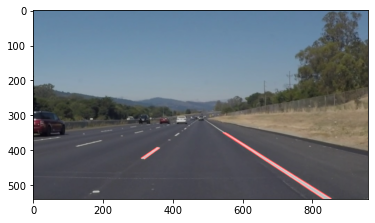

Input Image


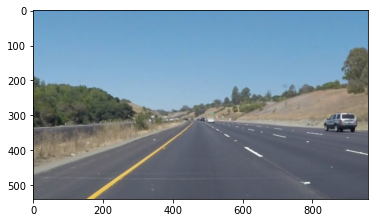

Canny edge detection on entire image


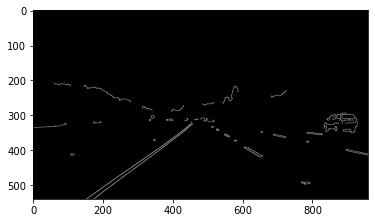

ROI applied to edge detected image


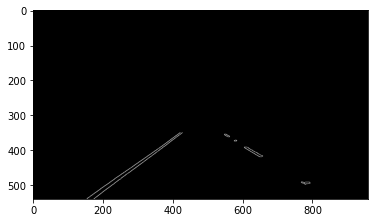

Hough Lines on ROI canny edge detected image


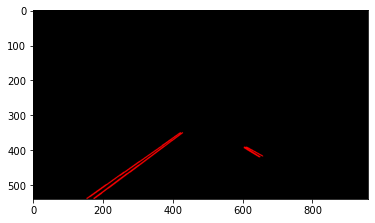

Lines on original image


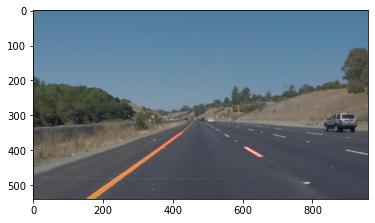

Input Image


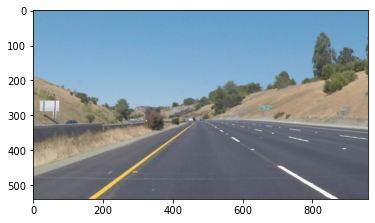

Canny edge detection on entire image


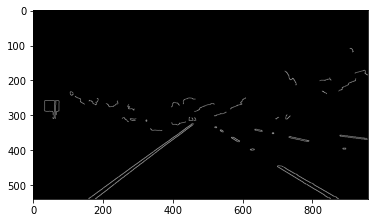

ROI applied to edge detected image


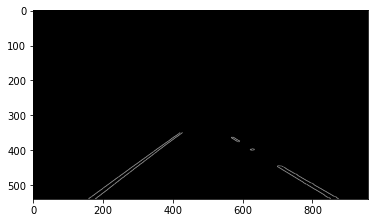

Hough Lines on ROI canny edge detected image


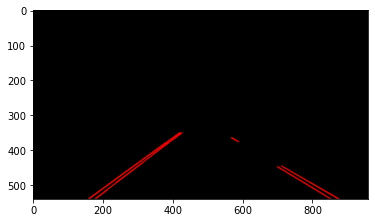

Lines on original image


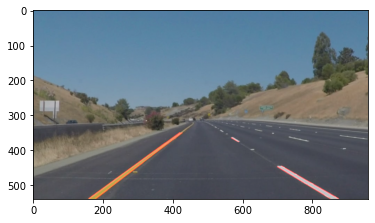

Input Image


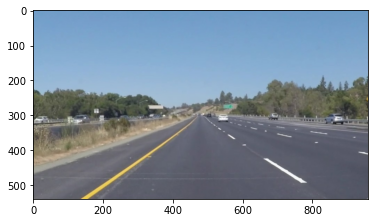

Canny edge detection on entire image


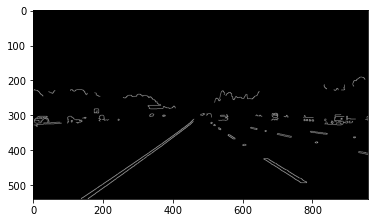

ROI applied to edge detected image


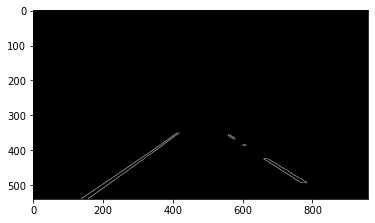

Hough Lines on ROI canny edge detected image


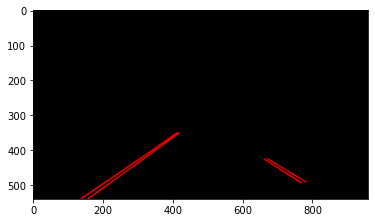

Lines on original image


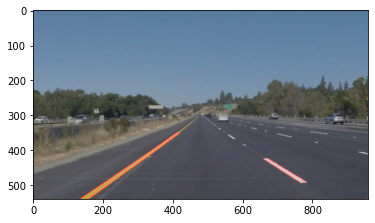

Input Image


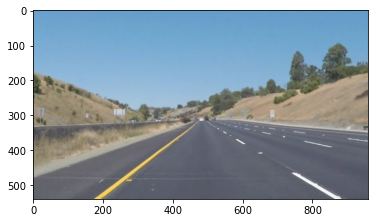

Canny edge detection on entire image


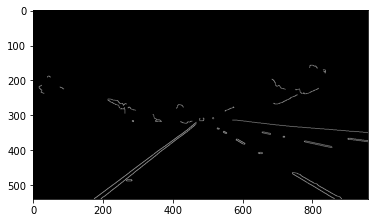

ROI applied to edge detected image


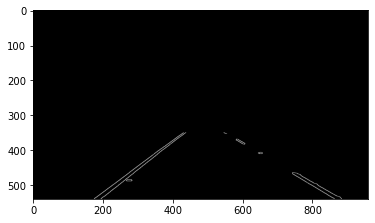

Hough Lines on ROI canny edge detected image


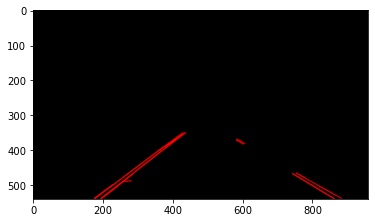

Lines on original image


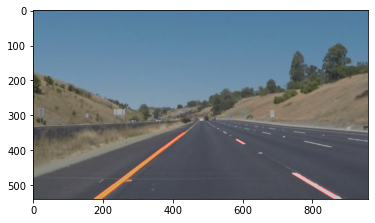

In [15]:
#display images after applying all the steps
detect_lane_images(extension = '_output.jpg')

## Test on Videos



In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
# Same pipeline which was used for individual images
def process_image(image):
    # Get the original Image
    input_image = image
                                 
    # Check if the image was loaded properly
    if input_image is None: 
        raise Exception("could not load image !")
    
    # Convert image to grayscale so that we can work with only single channel
    gray_image = grayscale(input_image)
    
    # Apply gaussian filtering to smoothen the image
    gauss_image = gaussian_blur(gray_image, 5)
    
    # Canny edge detection
    canny_image = canny(gauss_image, 120, 240)
    
    # ROI
    # A triangular polygon to segment the lane area and discarded other irrelevant parts in the image
    # Defined by three (x, y) coordinates    
    vertices = np.array([[(0, image.shape[0]), (400, 350), (550, 350), (image.shape[1], image.shape[0])]])
    ROI_image = region_of_interest(canny_image, vertices)
    
    # Probabilistic Hough lines
    rho = 1                  #Distance resolution in pixels
    theta = np.pi/180        #Angle resolution in radians
    threshold = 10           #Min. number of intersecting points to detect a line 
    min_line_length = 20     #Line segments shorter than this are rejected
    max_line_gap = 20        #Max gap allowed between line segments to treat them as a single line
    
    hough_image = hough_lines(ROI_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    result = weighted_img(hough_image, input_image)
    
    return result

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 9.75 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [28]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


t:   0%|                                                                             | 0/681 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 33.3 s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))